In [1]:
# 📌 Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transform: convert to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST from local files
train_dataset = torchvision.datasets.FashionMNIST(
    root="./", train=True, download=False, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./", train=False, download=False, transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Train size: 60000
Test size: 10000


In [3]:
# 📌 Step 3: Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Fashion-MNIST has 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()


In [4]:
# 📌 Step 4: Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
# 📌 Step 5: Training Loop
for epoch in range(2):  # increase for better accuracy
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/2], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/2], Loss: 0.4728
Epoch [2/2], Loss: 0.3109


In [6]:
# 📌 Step 6: Feature Map Visualization
def visualize_feature_maps(model, images):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    
    with torch.no_grad():
        x = F.relu(model.conv1(images))
        p = model.pool(x)
    
    for i in range(5):
        axs[0, i].imshow(x[0, i].cpu(), cmap="gray")
        axs[0, i].axis("off")
        axs[0, i].set_title(f"Conv1 Map {i+1}")
    
    for i in range(5):
        axs[1, i].imshow(p[0, i].cpu(), cmap="gray")
        axs[1, i].axis("off")
        axs[1, i].set_title(f"Pooled Map {i+1}")
    
    plt.suptitle("Feature Maps after Conv1 and Pooling", fontsize=16)
    plt.show()


True Label: 9


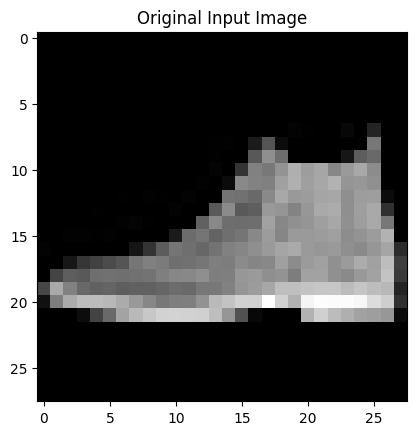

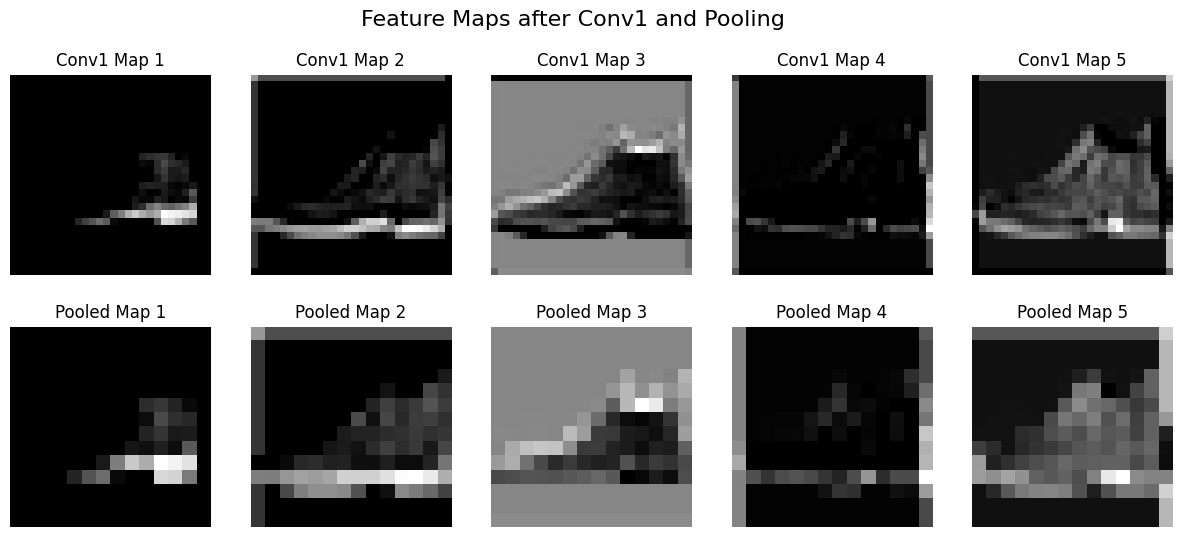

In [7]:
# 📌 Step 7: Test and Visualize
dataiter = iter(test_loader)
images, labels = next(dataiter)

print("True Label:", labels[0].item())
plt.imshow(images[0][0], cmap="gray")
plt.title("Original Input Image")
plt.show()

visualize_feature_maps(model, images)


✅ Test Accuracy: 88.86%

📊 Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.83      1000
     Trouser       0.96      0.98      0.97      1000
    Pullover       0.83      0.82      0.83      1000
       Dress       0.88      0.91      0.89      1000
        Coat       0.76      0.88      0.81      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.77      0.62      0.68      1000
     Sneaker       0.97      0.92      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.93      0.98      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



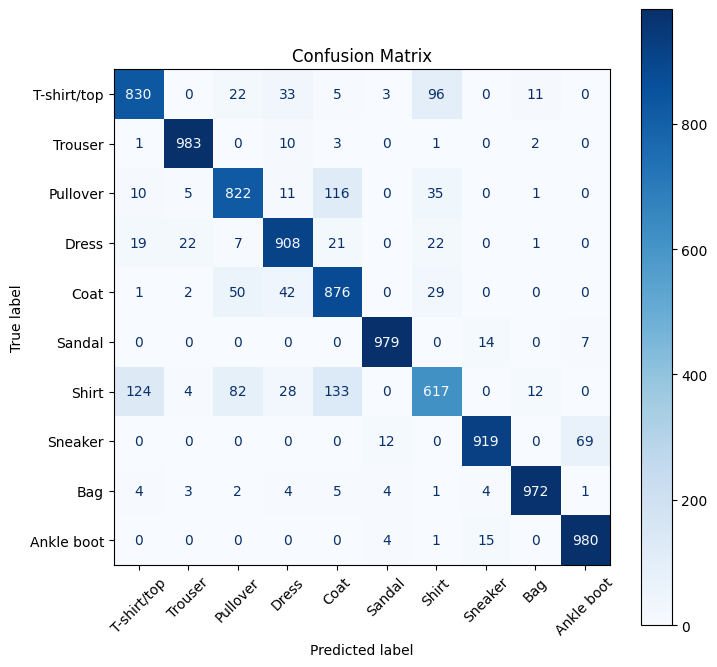

In [8]:
# %% 
# 📊 Step 8: Model Evaluation and Metrics Visualization

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ✅ Evaluate on test data
model.eval()
y_true, y_pred = [], []
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {accuracy:.2f}%\n")

# 📈 Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# 📉 Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# ✅ Optional: Plot Accuracy and Loss Curves (track during training)
# To make this work, modify your training loop slightly to store loss per epoch

# Example visualization (assuming you store epoch_loss in a list)
# For demonstration only; uncomment and use if you track metrics

# epochs = range(1, len(train_losses) + 1)
# plt.plot(epochs, train_losses, marker='o')
# plt.title("Training Loss over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.show()
